In [2]:
using Pkg

Pkg.add("Plots")

    Updating registry at `C:\Users\peren\.julia\registries\General`
    Updating git-repo `https://github.com/JuliaRegistries/General.git`
   Resolving package versions...
   Installed libfdk_aac_jll ─────────────── v2.0.2+0
   Installed GR_jll ─────────────────────── v0.64.2+0
   Installed Libmount_jll ───────────────── v2.35.0+0
   Installed JpegTurbo_jll ──────────────── v2.1.2+0
   Installed x265_jll ───────────────────── v3.5.0+0
   Installed Opus_jll ───────────────────── v1.3.2+0
   Installed LERC_jll ───────────────────── v3.0.0+1
   Installed Xorg_xkbcomp_jll ───────────── v1.4.2+4
   Installed Measures ───────────────────── v0.3.1
   Installed EarCut_jll ─────────────────── v2.2.3+0
   Installed Grisu ──────────────────────── v1.0.2
   Installed RelocatableFolders ─────────── v0.1.3
   Installed Xorg_xcb_util_wm_jll ───────── v0.4.1+1
   Installed Contour ────────────────────── v0.5.7
   Installed Xorg_xcb_util_image_jll ────── v0.4.0+1
   Installed PlotUtils ────────────────

  ✓ Plots
  103 dependencies successfully precompiled in 115 seconds (62 already precompiled)


Presolve 0 (-14) rows, 0 (-14) columns and 0 (-46) elements
Optimal - objective value 0
After Postsolve, objective 0, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 0 - 0 iterations time 0.002, Presolve 0.00
Presolve 0 (-15) rows, 0 (-14) columns and 0 (-47) elements
Optimal - objective value 38
After Postsolve, objective 38, infeasibilities - dual 0 (0), primal 0 (0)
Optimal objective 38 - 0 iterations time 0.002, Presolve 0.00
Presolve 13 (-2) rows, 10 (-4) columns and 38 (-9) elements
Perturbing problem by 0.001% of 0.84089642 - largest nonzero change 0.00017478229 ( 0.020785235%) - largest zero change 0.00017097627
0  Obj 27.436224 Primal inf 14.512423 (6)
7  Obj 33.949057
Optimal - objective value 33.9375
After Postsolve, objective 33.9375, infeasibilities - dual 0.2499999 (1), primal 0 (0)
Presolved model was optimal, full model needs cleaning up
0  Obj 33.9375
Optimal - objective value 33.9375
Optimal objective 33.9375 - 7 iterations time 0.012, Presolve 0.00
Preso

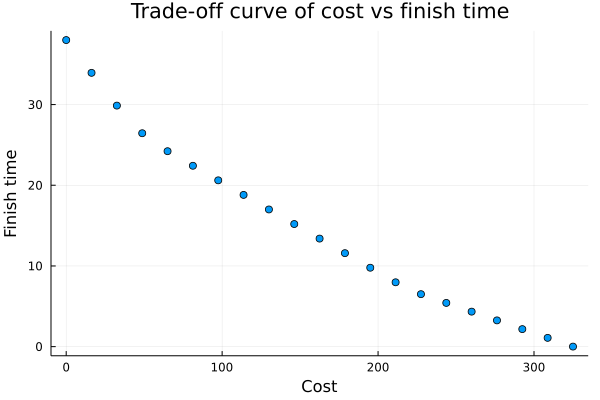

In [3]:
using JuMP, Cbc, Plots

activities = [:TW, :PRM, :SA1, :SA2, :ISA, :AS]
precedences = [(:TW,:SA1), (:TW,:SA2), (:PRM,:SA1), 
    (:PRM,:SA2), (:SA2,:ISA), (:SA1,:AS), (:ISA,:AS)]

duration = Dict(zip(activities, [6,9,8,7,10,12]))
redcost = Dict(zip(activities, [4,5,3,12,4,9]))

m = Model()

@variable(m, starttime[activities] >= 0)
@variable(m, 0 <= redamt[i in activities] <= duration[i])
@variable(m, totalcost)
@variable(m, finishtime >= 0)

@objective(m, Min, finishtime)

@constraint(m, minimax[i in activities], 
    finishtime >= starttime[i] + duration[i]- redamt[i])
@constraint(m, 
    precedence_relationships[(i,j) in precedences], 
    starttime[j] >= starttime[i] + duration[i]-redamt[i])

## define totalcost variable, 
## but for now there is no constraint on it
@constraint(m, totalcostdef,
    totalcost == 
    sum(redamt[i]*redcost[i] for i in activities))

set_optimizer(m, Cbc.Optimizer)

## First solve the model with no budget (in this case we
## know finish time will go to zero, but let's us
## calculate the cost, which is maximum we need to consider)
set_silent(m)
optimize!(m)

maxcost = value(totalcost)

## now add budget constraint
@constraint(m, budgetcon, totalcost <= 0.0)

## we'll divide budget range (0 to maxcost) into
## 21 values: [0,1/20*maxcost,...,19/20*maxcost,maxcost]
## and solve model with budget at each value
costs = Vector{Float64}(undef,21)
fintimes = Vector{Float64}(undef,21)
for i in 1:21
    B = (i-1)/20*maxcost
    
    ## following command updates the RHS of constraint
    set_normalized_rhs(budgetcon, B)
    
    ## re-solve the model
    set_silent(m)
    optimize!(m)
    
    ## store the outputs 
    ##  (note: don't use curbudget for cost
    ##        just in case budget not all used)
    costs[i] = value(totalcost)
    fintimes[i] = value(finishtime)
end

## create a scatter plot showing the pairs of objective values
scatter(costs,fintimes,
    title="Trade-off curve of cost vs finish time",
    xlabel="Cost",
    ylabel="Finish time",
    legend=false)

## use this command to store plot in a file 
## comment out the command and plot will be displayed in cell below
#savefig("tradeoffcurve.pdf")